<a href="https://colab.research.google.com/github/Thebestneminever/Deep-Learning-Projects/blob/main/image_to_image_translation_pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from IPython import display

In [ ]:
!pip install -q -U tensorboard


In [ ]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')


In [ ]:
BUFFER_SIZE =  400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image) # (256,256 + 256,3) # the real img of dim 256x256x256, and its facade of 256x256x256 
  # the real and its facade are concatenated along the width
  width = tf.shape(image)[1]# 512
  width = width//2 # 256 of each 
  real = image[:,:width,:] # the real building
  facade = image[:,width:,:] # the facade of the real bulding

  real = tf.cast(real,tf.float32)
  facade  = tf.cast(facade, tf.float32)

  return facade, real


The Facade
The Real


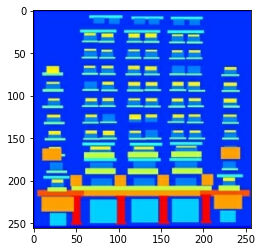

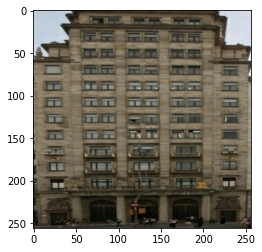

In [ ]:
fac, rea = load(PATH+'train/102.jpg')
plt.figure()
print("The Facade")
plt.imshow(fac/255.0)
plt.figure()

plt.imshow(rea/255)
print("The Real")

In [ ]:
def resize(facade, real, height, width): # resize 256x256x3 to 286x286x3
  facade = tf.image.resize(facade,size=(height, width), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real = tf.image.resize(real,size=(height, width), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return facade, real # (286x286x3)

In [ ]:
def random_crop(facade, real):# randomly crop 286,286,3 to 256,256,3
  stacked_image = tf.stack([facade,real],axis=0)
  cropped_image = tf.image.random_crop(stacked_image,size=[2,IMG_HEIGHT,IMG_WIDTH,3])
  return cropped_image[0], cropped_image[1]


In [ ]:
# random jitter
# 1. resize the image from 256x256x3 to 286x286x3
# 2. randomly crop the image to the target size = 256x256x3
# 3. randomly flip both the facade and its real 

In [ ]:
@tf.function
def random_jitter(facade, real):
  # resize 256x256x3 into 286,286,3
  facade, real = resize(facade,real,286,286) # (286,286,3)
  # now randomly crop to 256,256,3 --> final images size
  facade, real = random_crop(facade, real) # (256,256,3)

  # do random mirroring
  if tf.random.uniform(shape=()) > 0.5: # randomly flip the both the facade and its real
    facade = tf.image.flip_left_right(facade)
    real = tf.image.flip_left_right(real)

  return facade, real


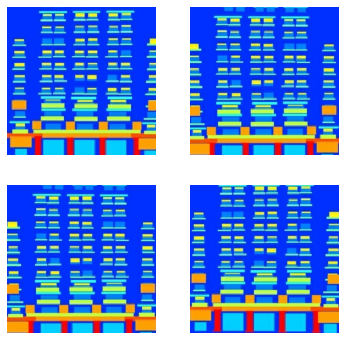

In [ ]:
plt.figure(figsize=(6,6))
for i in range(4):
  facade, real = random_jitter(fac,rea)
  plt.subplot(2,2,i+1)
  plt.imshow(facade/255.0)
  plt.axis("off")
plt.show()

In [ ]:
# normalize the images to (-1,1)
def normalize(facade, real):
  return (facade/127.5) -1, (real/127.5)-1

In [ ]:
def load_image_train(image_file): # train
  facade, real =  load(image_file) # load
  facade, real = random_jitter(facade, real) # upsize, crop to target size, flip
  facade, real = normalize(facade, real) # normalize into -1,1
  return facade, real


In [ ]:
def load_image_test(image_file): # test
  facade, real =  load(image_file) # load
  facade, real = resize(facade, real, IMG_HEIGHT, IMG_WIDTH) # assert target size
  facade, real = normalize(facade, real) # normalize into -1,1
  return facade, real

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg') # load all the paths of image files

# loading the facade and real from the path of the image
train_dataset = train_dataset.map(load_image_train,tf.data.experimental.AUTOTUNE)

# shuffle 400 vals in buffer
train_dataset = train_dataset.shuffle(BUFFER_SIZE) 

# batch of one
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE) # batch of one

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
# The generator is a U net, i.e. an encoder architecture with skip connections

def downsample(num_filters, size_kernel, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02) # initializer for kernel

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(num_filters, size_kernel, strides=2, padding="same",kernel_initializer=initializer, use_bias= not apply_batchnorm))
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())

  return result 

In [ ]:
fac.shape

TensorShape([256, 256, 3])

In [ ]:
down_model = downsample(3,4)
down_result = down_model(tf.expand_dims(fac,axis=0))
print(down_result.shape)

(1, 128, 128, 3)


In [ ]:
def upsample(num_filters, size_kernel, apply_dropout=False):
  initializer = tf.random_normal_initializer(mean=0,stddev=0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(num_filters, size_kernel, strides=2,padding="same", kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))
  result.add(tf.keras.layers.LeakyReLU())
  return result  

In [ ]:
up_model = upsample(3,4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [ ]:
def Generator():
  input_layer = tf.keras.layers.Input(shape=(256,256,3)) # the input tensor (not layer!)

  # inp = 256,256,3
  downsample_stack = [ # stack of sequential models 
  downsample(64,4,apply_batchnorm=False), # bszx128x128x64
  downsample(128,4), # bszx64x64x128
  downsample(256,4), # bszx32x32x256
  downsample(512,4), # bszx16x16x512
  downsample(512,4), # bszx8x8x512
  downsample(512,4), # bszx4x4x512
  downsample(512,4), # bszx2x2x512
  downsample(512,4), # bszx1x1x512
  ]

  # inp = 1,1,512, note that the + is due to concatentatoin of the skip connections 
  upsample_stack = [ # stack of sequential models
  upsample(512,4,apply_dropout=True), # 2,2, 512+ 512
  upsample(512,4,apply_dropout=True), # 4,4, 512 + 512
  upsample(512,4,apply_dropout=True), # 8,8, 512 + 512
  upsample(512,4), # 16,16, 512 + 512
  upsample(256,4), # 32,32,256 + 256
  upsample(128,4), # 64, 64, 128 + 128
  upsample(64,4), # 128,128,64 + 64
  ]

  initializer = tf.random_normal_initializer(mean=0, stddev=0.02)
  # the last layer
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,4,strides=2,padding="same",kernel_initializer=initializer
                                         ,activation="tanh") # (256,256,3) in [-1,1] values of pixels
  x = input_layer # the input layer
  skips = [] # for skip connection
  # downsampling through the generator
  for down in downsample_stack:
    x = down(x) # down
    skips.append(x) # store it in skips
  skips = reversed(skips[:-1]) # reverse skips

  # Upsampling through the generator, and concatenating the skip connections
  for up,skip in zip(upsample_stack,skips):
    x = up(x) # up
    # the concatenate LAYER
    x = tf.keras.layers.Concatenate(axis=-1)([x,skip]) # concatenate along the last/channel dim for skip connection

  fake = last(x) # returns image pixel values [-1,1]

  return tf.keras.Model(inputs=input_layer, outputs=fake)

  # so what we did was
  # we passed our input through the different layers of the generator (i.e. the sequential models)
  # and then we generated the output
  # i.e. WE JUST DEFINED THE COMPUTATION GRAPH
  # and then we made the overall model, with the corresponding inputs and outputs
  # But why did we do like this ?
  # Essentially because we wanted to incorporate the SKIP CONNECTIONS
  # But, dont worry, this model could have also been created by defining a custom class and stuff :)



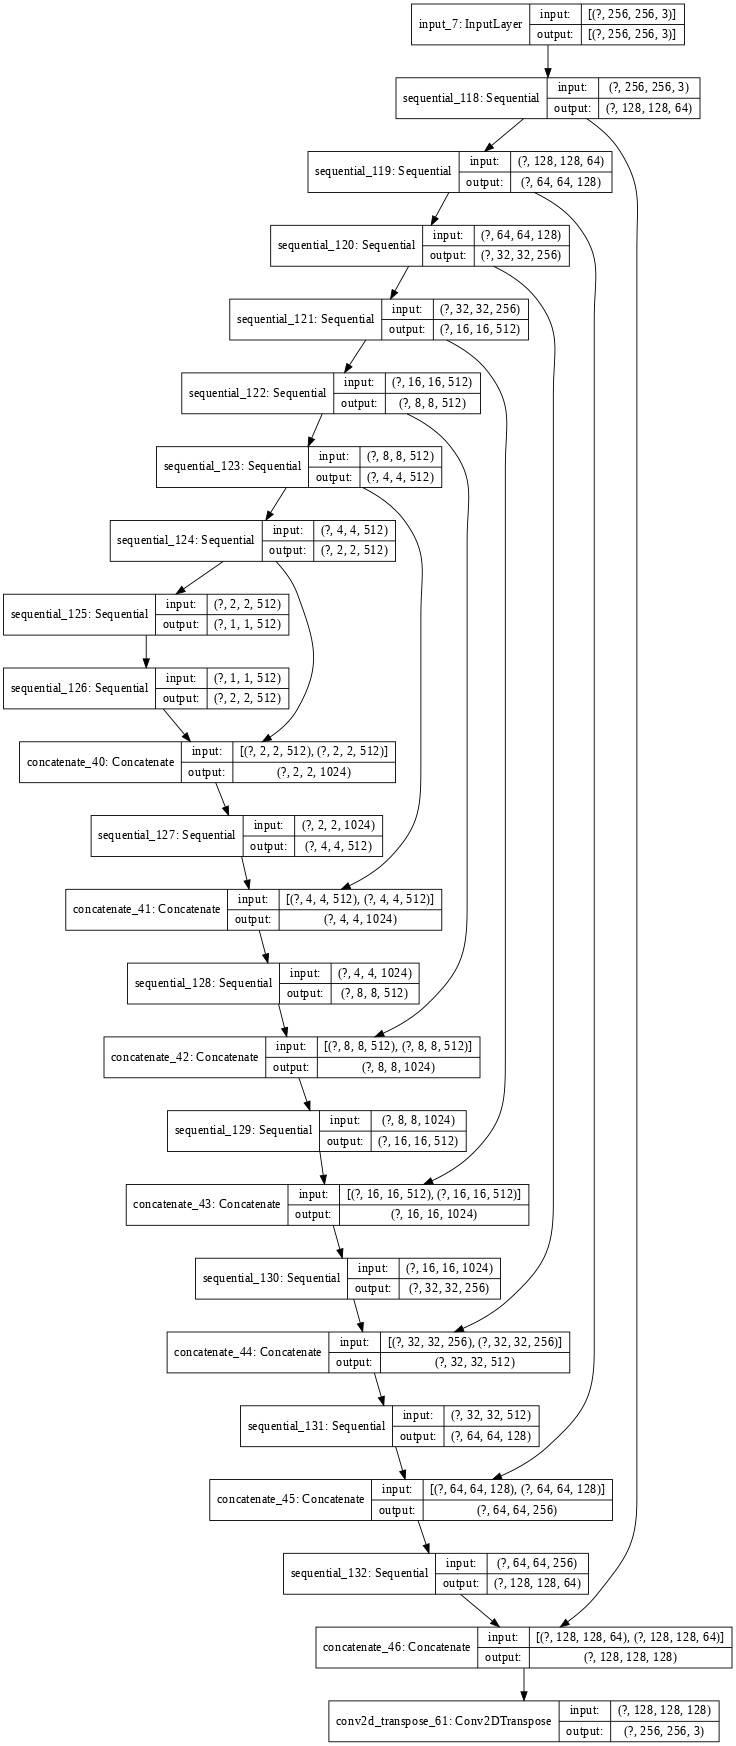

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


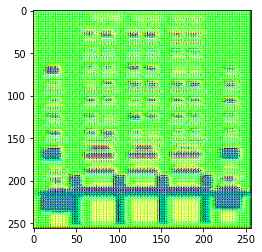

In [ ]:
gen_op = generator(tf.expand_dims(fac,0),training=False)
plt.imshow(gen_op[0,:,:,:]) # remember the output_pixels are in the range [-1,1] due tanh

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# Generator Loss = GAN_LOSS + LAMBDA*L1_LOSS
# The L1_Loss is b/w the generated image and the true image
LAMBDA = 100 # as per the authors
def generator_loss(discriminator_output_when_input_is_fake_image, fake, true):
  disc_op = discriminator_output_when_input_is_fake_image
  generated_image = fake
  target_image = true
  my_ones = tf.ones(disc_op.shape)
  gan_loss = loss_object(my_ones, disc_op)
  l1_loss = LAMBDA*tf.reduce_mean(tf.abs(generated_image-target_image))
  total_loss = gan_loss + l1_loss
  return total_loss, gan_loss, l1_loss


In [ ]:
# Discriminator 
# patchGan
def Discriminator():
  initializer = tf.random_normal_initializer(mean=0.0,stddev=0.02)

  # The facade
  facade = tf.keras.layers.Input(shape=(256,256,3),name="facade_image") # the input  tensor (not a layer!)
  
  # Either the real image of the facade, or the one generated by the generator
  target = tf.keras.layers.Input(shape=(256,256,3), name="true_image") # the input tensor (not a layer!)

  # concatenate the facade and the target
  x = tf.keras.layers.Concatenate(axis=-1)([facade,target]) # 256,256,3+3

  # downsample via convolutions
  x = downsample(64,4,False)(x) # 128,128,64
  x = downsample(128,4)(x) # 64,64,128
  x = downsample(256,4)(x) # 32,32,256

  # zero padding 
  x = tf.keras.layers.ZeroPadding2D()(x) # 1+32+1, 1+32+1, 256 --> 34,34,256
  
  # convolution
  x = tf.keras.layers.Conv2D(512,4,1,padding="valid",kernel_initializer=initializer,use_bias=False)(x) # 31,31,512

  # batchnorm
  x = tf.keras.layers.BatchNormalization()(x) # 31,31,512

  # relu
  x = tf.keras.layers.LeakyReLU()(x) # 31,31,512

  # zero padding again
  x = tf.keras.layers.ZeroPadding2D()(x) # 1+31+1,1+31+1,512 --> 33,33,512

  #convolution 30,30,1 PATCHGAN
  # the outputs are logits 30x30x1
  x = tf.keras.layers.Conv2D(1,4,1,padding="valid",kernel_initializer=initializer)(x) # 30,30,1

  return tf.keras.Model(inputs=[facade,target],outputs=x)



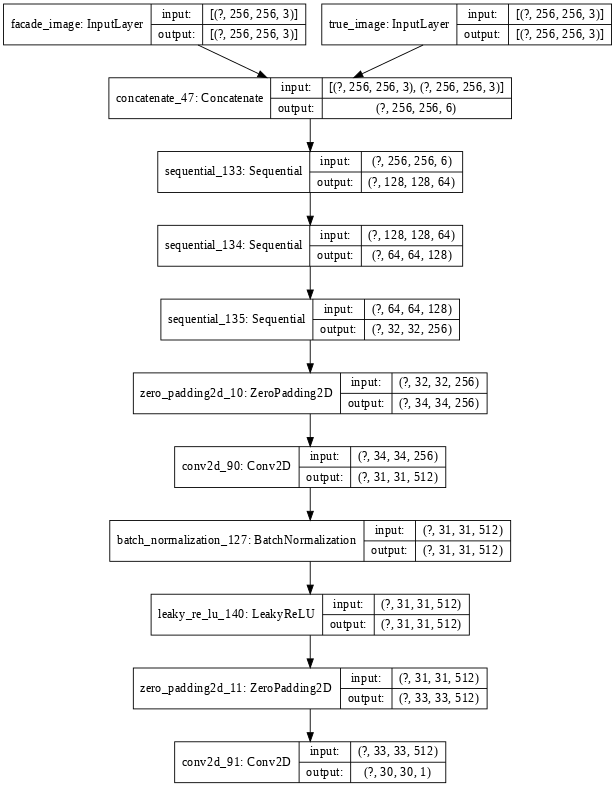

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

(1, 30, 30, 1)


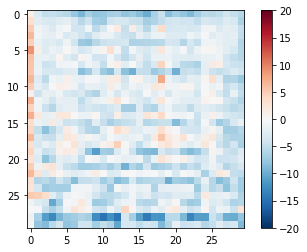

In [ ]:
disc_out  = discriminator([tf.expand_dims(fac,0),gen_op],training=False)
print(disc_out.shape)
plt.imshow(disc_out[0,:,:,0],vmin=-20,vmax=20,cmap="RdBu_r")
plt.colorbar()

In [ ]:
# Discriminator Loss
# it takes 2 inputs, real images and fake/generated image
def discriminator_loss(disciminator_output_when_input_real,disciminator_output_when_input_fake):
  d_r = disciminator_output_when_input_real
  d_f = disciminator_output_when_input_fake

  my_ones  = tf.ones(d_r.shape)
  real_img_loss = loss_object(my_ones,d_r)

  my_zeros = tf.zeros(d_f.shape)
  fake_img_loss = loss_object(my_zeros,d_f)

  total_loss = real_img_loss + fake_img_loss
  return total_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4,beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [ ]:
def generate_images(model, test_facade, test_real, training=False):
  fake = model(test_facade, training=training)
  plt.figure(figsize=(15,15))
  display_list = [test_facade[0],test_real[0],fake[0]] # all pixel values in range of [-1,1]
  names = ["Facade","Real","Generated"]
  for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(names[i])
    plt.imshow(display_list[i]*0.5 + 0.5) # to bring pixel values in (0,1)
    plt.axis("off")
  plt.show


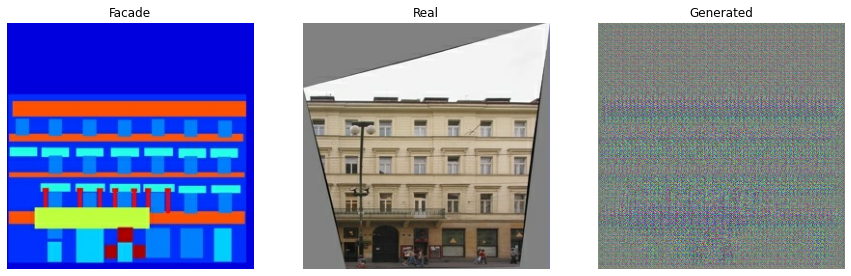

In [ ]:
for ex_fac,ex_rea in test_dataset.take(1):
  generate_images(generator,ex_fac,ex_rea,True)

In [ ]:
# training
# 1. for each facade, generate a fake image
# 2. (facade,fake_img) --> input to the disciminator
# 3. (facade,real_img) --> input to disciminator
# 4. Loss of disciminator
# 5. Loss of generator
# 6. Gradient descent
# repeat

In [ ]:
EPOCHS = 150 # total epochs
import datetime
log_dir = "logsfinal/" # logs/fit will have all the training log
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(facade,real,epoch):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    fake = generator(facade, training=True) # generate fake images
    disc_fake_op = discriminator([facade,fake],training=True) # logits for fake from discriminator
    disc_real_op = discriminator([facade,real],training=True) # logits for real from discriminator
    disc_loss = discriminator_loss(disc_real_op,disc_fake_op) # discriminator loss
    gen_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_fake_op,fake,real) # the generator loss
  
  disc_trainable_params = discriminator.trainable_variables # discriminator trainable params
  # the disc_tape will calculate the gradients of the discriminator 
  disc_grad = disc_tape.gradient(disc_loss, disc_trainable_params) # calc the gradient of discriminator wrt its loss

  gen_trainable_params = generator.trainable_variables # generators trainable params
  # the gen_tape will calculate the gradient of the generator
  gen_grad = gen_tape.gradient(gen_loss, gen_trainable_params)

  # apply the gradients
  discriminator_optimizer.apply_gradients(zip(disc_grad,disc_trainable_params))
  generator_optimizer.apply_gradients(zip(gen_grad,gen_trainable_params))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)


In [ ]:
def fit(train_dataset,test_dataset,epochs):
  for epoch in range(epochs):
    display.clear_output(wait=True) # clear the display

    # visualize learning
    for ex_facade, ex_real in test_dataset.take(1): # just see the progress of training
      # visualize how the generator learns to make images as training progresses
      generate_images(generator, ex_facade,ex_real,training=True) # note that training = True
      # this is because the images that the generator makes are all in the training mode = True
      # so the training mode = True will only give the correct images that the generator learns to make
    print(f"\n\nEpoch: {epoch}")

    # training 
    
    i = 0 # number of examples
    for facade, real in train_dataset:
      i += 1
      if i%100 == 0:
        print()
      print(".",end='')
      train_step(facade,real,epoch)
    print()

    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  checkpoint.save(file_prefix = checkpoint_prefix)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
fit(train_dataset,test_dataset,EPOCHS)



Epoch: 127
...................................................................................................
....................................................................................................
....